In [280]:
import os
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.qhull import Delaunay

C:\Users\23657\AppData\Local\Temp\ipykernel_16724\199303868.py:6: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay


**Note**: It takes 7 min to run this code

0. Load Images


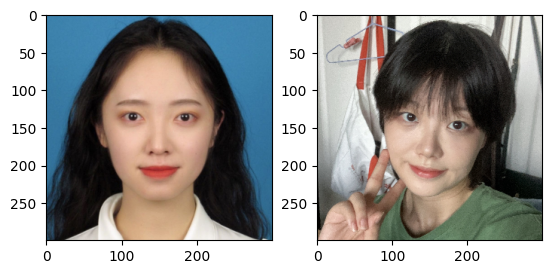

In [281]:
#I use photos of me and my friend
path_1 = "face1.jpg"
path_2 = "face4.jpg"

face1_img = plt.imread(path_1)
face2_img = plt.imread(path_2)

#make them the same size
w = 300
h = 300

face1 = cv2.resize(face1_img, (w, h))
face2 = cv2.resize(face2_img, (w, h))

#display these images
plt.subplot(1, 2, 1)
plt.imshow(face1)

plt.subplot(1, 2, 2)
plt.imshow(face2)
plt.show()

1. Find Feature Points:   I use dlib to generate 68 ficial feature points and choose 12 points on the edges

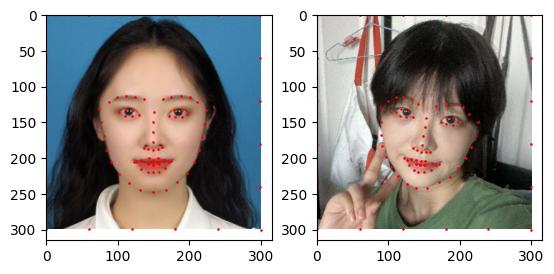

In [282]:
model_path = "shape_predictor_68_face_landmarks.dat"

#detect featrue points on faces using dilb
detector = dlib.get_frontal_face_detector()

#load predictor
predictor = dlib.shape_predictor(model_path)

def get_landmarks(img):
    #img_copy = img.copy()
    h, w, _ = img.shape
    landmarks = []
    
    #get ficial points
    dets1 = detector(img, 1)
    for face in dets1:
        shape = predictor(img, face)

        for pt in shape.parts():                          
            landmarks.append([pt.x, pt.y])
    
    #get points on edges
    step = 5
    for i in range (0, w, w//step):
        if [0, i] not in landmarks:
            landmarks.append([0, i])
        if [h - 1, i] not in landmarks:
            landmarks.append([h - 1, i])

    for j in range (0, h, h//step):
        if [j, 0] not in landmarks:
            landmarks.append([j, 0])
        if [j, w - 1] not in landmarks:
            landmarks.append([j, w - 1])
    landmarks.append([h, w])

    landmarks = np.array(landmarks)
    
    return landmarks

#get landmarks of 2 face images
landmarks1 = get_landmarks(face1)
landmarks2 = get_landmarks(face2)

# #display images with landmarks
plt.subplot(1, 2, 1)
plt.imshow(face1)
plt.scatter(landmarks1[:, 0], landmarks1[:, 1], color='red', marker='.', s=3)

plt.subplot(1, 2, 2)
plt.imshow(face2)
plt.scatter(landmarks2[:, 0], landmarks2[:, 1], color='red', marker='.', s=3)

plt.show()



2. Create a triangulation and visualise it

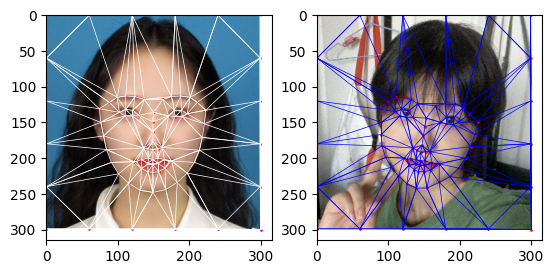

(162, 3)
(162, 3, 2)


In [283]:
#creat Delaunay triangulation
triangulation = Delaunay(landmarks1)
#get indices of vertices
triangles = triangulation.simplices

#visualize triangles
plt.subplot(1, 2, 1)
plt.imshow(face1)
plt.scatter(landmarks1[:, 0], landmarks1[:, 1], color='red', marker='.', s=3)
for tri in triangles:    
    plt.plot(landmarks1[tri, 0], landmarks1[tri, 1], color='white', linewidth=0.5)

plt.subplot(1, 2, 2)
plt.imshow(face2)
plt.scatter(landmarks2[:, 0], landmarks2[:, 1], color='red', marker='.', s=3)
for tri in triangles:
    plt.plot(landmarks2[tri, 0], landmarks2[tri, 1], color='b', linewidth=0.5)

plt.show()

print(triangles.shape)
print(landmarks1[triangles].shape)

3. Create the intermediate image coordinates in all “in between” images for all the

    vertices of all triangles by linearly interpolating between the start and end positions.


In [284]:
def interpolate_pts(start_points, end_points, weight):
    return (1 - weight) * start_points + weight * end_points

#interpolate 50 "in between" triangles
nStep = 50

interm_pts = []
for i in range (nStep):
    weight = i / nStep
    interm_pt = interpolate_pts(landmarks1, landmarks2, weight)
    interm_pts.append(interm_pt)

interm_pts = np.array(interm_pts)
print(interm_pts.shape)
# print(interm_pts[5, :5, :])
# print(landmarks1[:5, :])
# print(landmarks2[:5, :])

(50, 88, 2)


4. For every pair of corresponding triangles, take the 3 pairs of corresponding vertices
and estimate an Affine warp.

In [285]:
def calcAffineMat(start_tri,end_tri):
    A = np.array([
    [start_tri[0, 0], start_tri[0, 1], 1, 0, 0, 0],
    [0, 0, 0, start_tri[0, 0], start_tri[0, 1], 1],
    [start_tri[1, 0], start_tri[1, 1], 1, 0, 0, 0],
    [0, 0, 0, start_tri[1, 0], start_tri[1, 1], 1],
    [start_tri[2, 0], start_tri[2, 1], 1, 0, 0, 0],
    [0, 0, 0, start_tri[2, 0], start_tri[2, 1], 1]
    ])
    B = np.array([end_tri[0, 0], end_tri[0, 1], end_tri[1, 0], end_tri[1, 1], end_tri[2, 0], end_tri[2, 1]])

    # identify whether A is singular(whether the three points of the triangle are collinear)
    if np.linalg.det(A) != 0:
        # Solve the linear equation A * X = B for X
        X = np.linalg.solve(A, B)
        X = X.reshape(2, 3)
        return X

In [286]:
def applyAffineWarp(pixel, affine_mat):    
    homo_pixel = np.array([pixel[0][0], pixel[0][1], 1])
    new_coord = affine_mat @ homo_pixel
            
    return new_coord

5. Map all corresponding points between the triangles.

6. Apply blending

In [287]:
def bilinear_interpolation(image, x, y):
    x0, y0 = int(x), int(y)
    
    x0 = np.clip(x0, 0, image.shape[1] - 1)
    y0 = np.clip(y0, 0, image.shape[0] - 1)
    
    x1, y1 = x0 + 1, y0 + 1

    if x1 >= image.shape[0]:
        x1 = x0
    if y1 >= image.shape[1]:
        y1 = y0

    Ia = image[y0, x0]
    Ib = image[y1, x0]
    Ic = image[y0, x1]
    Id = image[y1, x1]

    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    interpolated_value = wa * Ia + wb * Ib + wc * Ic + wd * Id
    return interpolated_value



In [288]:
#calculate each frame "in between"
img_sequences = []
img_sequences.append(face1)


for k in range(1, nStep):
    print(f"Processing the No.{k} frame...")
    weight = k / nStep
    img_sequence = np.zeros((h, w, 3))

    curr_landmasks = interm_pts[k, :, :]
    
    #calculate affine matrix between triangles in each frame
    Affine_mats_frame2face1 = []
    Affine_mats_frame2face2 = []
    for tri in triangles:
        # Note that we use the inverse warp instead of the forward warp
        curr_tri = curr_landmasks[tri]
        
        face1_tri = landmarks1[tri]
        face2_tri = landmarks2[tri]
        #print(face1_tri.shape)
        # Note that we use the inverse warp instead of the forward warp
        affine_frame2face1 = calcAffineMat(curr_tri, face1_tri)
        affine_frame2face2 = calcAffineMat(curr_tri, face2_tri)
        #print(curr_tri.shape)

        Affine_mats_frame2face1.append(affine_frame2face1)
        Affine_mats_frame2face2.append(affine_frame2face2)



    # Calculate the position and color of each transformed pixel in kth frame
    for i in range(h):
        for j in range(w):
            idx = triangulation.find_simplex([i, j]) #Identify the indices of the triangles that encompass the specified point.
            #print(idx)
            affine_frame2face1 = Affine_mats_frame2face1[idx] #Identify the affine transformation matrix corresponding to this triangle
            affine_frame2face2 = Affine_mats_frame2face2[idx]

            start_pt = np.array([[i, j]]) 
            end_pt_face1 = applyAffineWarp(start_pt, affine_frame2face1)
            end_pt_face2 = applyAffineWarp(start_pt, affine_frame2face2)
            #print(end_pts_face1.shape)
            
            color_face1 = bilinear_interpolation(face1, end_pt_face1[0], end_pt_face1[1])
            color_face2 = bilinear_interpolation(face2, end_pt_face2[0], end_pt_face2[1])
            # Blending            
            img_sequence[j, i] = (1 - weight) * color_face1 + weight * color_face2
            #temp_img[i, j] = color

    #warped_start_img = temp_img
    img_sequences.append(img_sequence)

img_sequences.append(face2)
    





Processing the No.1 frame...
Processing the No.2 frame...
Processing the No.3 frame...
Processing the No.4 frame...
Processing the No.5 frame...
Processing the No.6 frame...
Processing the No.7 frame...
Processing the No.8 frame...
Processing the No.9 frame...
Processing the No.10 frame...
Processing the No.11 frame...
Processing the No.12 frame...
Processing the No.13 frame...
Processing the No.14 frame...
Processing the No.15 frame...
Processing the No.16 frame...
Processing the No.17 frame...
Processing the No.18 frame...
Processing the No.19 frame...
Processing the No.20 frame...
Processing the No.21 frame...
Processing the No.22 frame...
Processing the No.23 frame...
Processing the No.24 frame...
Processing the No.25 frame...
Processing the No.26 frame...
Processing the No.27 frame...
Processing the No.28 frame...
Processing the No.29 frame...
Processing the No.30 frame...
Processing the No.31 frame...
Processing the No.32 frame...
Processing the No.33 frame...
Processing the No.3

7. Make a video with all the “in between” images

In [289]:
#save images sequences
output_folder = "./image_sequences"
os.makedirs(output_folder, exist_ok=True)

for i, image in enumerate(img_sequences):
    filename = os.path.join(output_folder, f"frame_{i + 1:03d}.png")
    cv2.imwrite(filename, cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2BGR))

In [290]:
# create a video for 50 image frames
image_folder = './image_sequences'
video_path = './video.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images.sort()


frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width = frame.shape[:2]

# video encoder
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# video object
fps = 10
video = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))
video.release()
